<a href="https://colab.research.google.com/github/moridin04/Data-Science-Project/blob/main/Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science - Course Project**

**Analyzing Factors Influencing Writing Productivity Through Machine Learning Models**

**Goal:** To determine which daily factors (Sleep, Reading, Device) maximize my writing productivity

**Findings:**
- The writing hours show high variance and irregular spikes, suggesting a burst-based ("sprint") writing pattern rather than consistent daily output.

- **Fantasy** entries show higher mean writing hours and strong predictive importance, whereas **Shonen** entries proved to be weak predictors in the model.

- **Mood differences** produced only small changes in mean writing hours, indicating mood is likely a weak predictor.

- **Correction on Device Usage:** Previous analysis suggested 'Mode of Writing' was the strongest predictor. However, this was identified as **data leakage** (since 'No Mode' always equals '0 Hours'). After removing this leak, we see that device choice (Phone vs Desktop) has a more modest impact.

- A weak negative correlation (-0.21) suggests slightly higher writing hours on lower sleep days.

- Scenario 3 (Emotional) produced the highest predicted output (5.81 hours). As the diagnostics will show, this is likely driven by **Vacation** days having a strong positive weight, rather than the "Horror" genre itself.

**Limitations:** The dataset contains a small number of samples and several categories with low counts, which may introduce noise and limit generalizability. Findings should therefore be interpreted as exploratory rather than definitive.

## **PHASE 1: Data Preparation**

### **Importing**

**Importing Libraries**

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import IPython.display
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

### **Dataset**

**Dataset**

In [182]:
url = "https://raw.githubusercontent.com/moridin04/Data-Science-Project/refs/heads/main/datascience-dataset-official.csv"

df = pd.read_csv(url, keep_default_na=False, na_values=[''])

In [183]:
df

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,12/14/25,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,12/15/25,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,12/16/25,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,N/A,School
3,1,4,12/17/25,8.1,0.0,N/A,N/A,N/A,Neutral,Yes,2,Phone,School
4,1,5,12/18/25,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,12/19/25,7.1,1.0,11/22/63,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,12/20/25,8.9,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
7,2,8,12/21/25,7.8,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
8,2,9,12/22/25,7.7,1.0,House of Chains,Steven Erikson,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,12/23/25,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


In [184]:
df.columns = df.columns.str.strip()

inconsistent = df[(df['Did I write today?'] == 'No') & (df['Hours of Writing'] > 0)]
if not inconsistent.empty:
    print("Rows where 'No writing' but hours > 0:")
    print(inconsistent[['Day', 'Did I write today?', 'Hours of Writing', 'Mode of Writing']])

inconsistent2 = df[(df['Did I write today?'] == 'Yes') & (df['Hours of Writing'] > 0) & (df['Mode of Writing'].isna())]
if not inconsistent2.empty:
    print("Rows where writing happened but Mode of Writing is missing:")
    print(inconsistent2[['Day', 'Did I write today?', 'Hours of Writing', 'Mode of Writing']])

**Columns**

In [185]:
df.columns

Index(['Week', 'Day', 'Date', 'Hours of Sleep', 'Hours of Reading Time',
       'Book Titles', 'Authors', 'Genres', 'Mood Impact (Happy, Neutral, Sad)',
       'Did I write today?', 'Hours of Writing', 'Mode of Writing',
       'Type of Day'],
      dtype='object')

**Shape of Dataset**

In [186]:
df.shape

(56, 13)

**Numerical Features**

In [187]:
df.select_dtypes(include=['number']).columns

Index(['Week', 'Day', 'Hours of Sleep', 'Hours of Reading Time',
       'Hours of Writing'],
      dtype='object')

**Categorical Features**

In [188]:
df.select_dtypes(include=['object']).columns

Index(['Date', 'Book Titles', 'Authors', 'Genres',
       'Mood Impact (Happy, Neutral, Sad)', 'Did I write today?',
       'Mode of Writing', 'Type of Day'],
      dtype='object')

**Describing the Dataset**

In [189]:
df.describe()

,Week,Day,Hours of Sleep,Hours of Reading Time,Hours of Writing
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,4.500000,28.500000,7.225000,1.196429,2.750000
std,2.312024,16.309506,0.998772,1.423563,1.739906
min,1.000000,1.000000,5.200000,0.000000,0.000000
25%,2.750000,14.750000,6.475000,0.000000,2.000000
50%,4.500000,28.500000,7.150000,1.000000,3.000000
75%,6.250000,42.250000,8.025000,2.000000,4.000000
max,8.000000,56.000000,9.100000,6.000000,7.000000


**Dataset Information**

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week                               56 non-null     int64  
 1   Day                                56 non-null     int64  
 2   Date                               56 non-null     object 
 3   Hours of Sleep                     56 non-null     float64
 4   Hours of Reading Time              56 non-null     float64
 5   Book Titles                        56 non-null     object 
 6   Authors                            56 non-null     object 
 7   Genres                             56 non-null     object 
 8   Mood Impact (Happy, Neutral, Sad)  56 non-null     object 
 9   Did I write today?                 56 non-null     object 
 10  Hours of Writing                   56 non-null     int64  
 11  Mode of Writing                    56 non-null     object 
 

## **PHASE 2: Exploratory Data Analysis (EDA)**

### **Cleaning**

**Structuring**

In [191]:
df.dtypes

,0
Week,int64
Day,int64
Date,object
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


**Indexing**

In [192]:
df.index

RangeIndex(start=0, stop=56, step=1)

**Duplication Check**

In [193]:
df.duplicated().sum()
df.shape

(56, 13)

**Conversion to Correct Data Types**

In [194]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df.dtypes

,0
Week,int64
Day,int64
Date,datetime64[ns]
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


In [195]:
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,N/A,School
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,N/A,Neutral,Yes,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,2025-12-19,7.1,1.0,11/22/63,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,2025-12-20,8.9,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
7,2,8,2025-12-21,7.8,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Erikson,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


**Transforming Data**

In [196]:
df['Did I write today?'] = df['Did I write today?'].map({'Yes': 1, 'No': 0})
df.head()

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,1,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,0,0,N/A,School
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,N/A,Neutral,1,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Desktop,School


**Filling Null Values**

In [197]:
df.fillna(0, inplace=True)
print(df.to_string())

    Week  Day       Date  Hours of Sleep  Hours of Reading Time                                      Book Titles                                     Authors                   Genres Mood Impact (Happy, Neutral, Sad)  Did I write today?  Hours of Writing Mode of Writing Type of Day
0      1    1 2025-12-14             7.6                    2.0                                  Memories of Ice                              Steven Erikson                  Fantasy                               Sad                   1                 2         Desktop      School
1      1    2 2025-12-15             7.2                    4.3                                  Memories of Ice                              Steven Erikson                  Fantasy                             Happy                   1                 2           Phone      School
2      1    3 2025-12-16             6.8                    4.2                                  Memories of Ice                              Steven Eriks

**Splitting Genres**

In [198]:
df['Genres'].str.split(', ')

,Genres
0,[Fantasy]
1,[Fantasy]
2,[Fantasy]
3,[N/A]
4,[Fantasy]
5,[Fiction]
6,[N/A]
7,[N/A]
8,[Fantasy]
9,[Memoir]


In [199]:
split_genres = df['Genres'].str.split(', ', expand=True)

In [200]:
df = pd.concat([df, split_genres], axis=1)
df = df.drop(columns=['Genres'])
df = df.rename(columns={0: 'Genre 1', 1: 'Genre 2', 2: 'Genre 3'})
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day,Genre 1,Genre 2,Genre 3
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Sad,1,2,Desktop,School,Fantasy,None,None
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Happy,1,2,Phone,School,Fantasy,None,None
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Neutral,0,0,N/A,School,Fantasy,None,None
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,Neutral,1,2,Phone,School,N/A,None,None
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Happy,1,2,Desktop,School,Fantasy,None,None
5,1,6,2025-12-19,7.1,1.0,11/22/63,Stephen King,Happy,1,2,Desktop,School,Fiction,None,None
6,1,7,2025-12-20,8.9,0.0,N/A,N/A,Happy,1,2,Phone,School,N/A,None,None
7,2,8,2025-12-21,7.8,0.0,N/A,N/A,Happy,1,2,Phone,School,N/A,None,None
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Erikson,Happy,1,2,Phone,Vacation,Fantasy,None,None
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Neutral,1,4,Phone,Vacation,Memoir,None,None


In [201]:
df_clean = df.copy()
genre_cols = ['Genre 1', 'Genre 2', 'Genre 3']
combined_genres = pd.get_dummies(df_clean[genre_cols].stack()).groupby(level=0).max().add_prefix('Genre_')

**Dropping Columns**

In [202]:
cols_to_drop = ['Week ', 'Date', 'Book Titles', 'Did I write today?', 'Authors', 'Genre 1', 'Genre 2', 'Genre 3']
existing_drops = [c for c in cols_to_drop if c in df_clean.columns]
df_clean = df_clean.drop(columns=existing_drops)
df_final = pd.concat([df_clean, combined_genres], axis=1)

**Encoding Categoricals and Handling Data Leakage**

In [203]:
categorical_cols = ['Mood Impact (Happy, Neutral, Sad)', 'Type of Day', 'Mode of Writing']
existing_cats = [c for c in categorical_cols if c in df_final.columns]

df_encoded = pd.get_dummies(df_final, columns=existing_cats, drop_first=True)
df_encoded = df_encoded.fillna(0)

leakage_cols = [c for c in df_encoded.columns
                if 'Mode of Writing' in c
                and ('nan' in c.lower() or '0' in c or 'n/a' in c.lower())]

if leakage_cols:
    print(f"Dropping Leakage Columns: {leakage_cols}")
    df_encoded = df_encoded.drop(columns=leakage_cols)
else:
    print("No leakage columns found (Clean).")

target_variable = 'Hours of Writing'
correlations = df_encoded.corr()[target_variable].sort_values(ascending=False)

print("\nUpdated Correlations (Top 5):")
print(correlations.head(5))

Dropping Leakage Columns: ['Mode of Writing_N/A']

Updated Correlations (Top 5):
Hours of Writing         1.000000
Mode of Writing_Phone    0.422484
Day                      0.166588
Week                     0.153673
Genre_Shonen             0.126480
Name: Hours of Writing, dtype: float64


In [204]:
target_variable = 'Hours of Writing'
correlations = df_encoded.corr()[target_variable].sort_values(ascending=False)

**Feature Correlation with "Hours of Writing" (Writing Productivity)**

Feature Correlation with 'Hours of Writing': 
Hours of Writing                             1.000000
Mode of Writing_Phone                        0.422484
Day                                          0.166588
Week                                         0.153673
Genre_Shonen                                 0.126480
Genre_Memoir                                 0.097750
Type of Day_Vacation                         0.059791
Mood Impact (Happy, Neutral, Sad)_Sad        0.034494
Mood Impact (Happy, Neutral, Sad)_Neutral    0.026040
Genre_Fantasy                                0.015544
Genre_Horror                                -0.027238
Genre_Fiction                               -0.058650
Hours of Reading Time                       -0.070837
Genre_N/A                                   -0.074217
Type of Day_Weekend                         -0.120636
Hours of Sleep                              -0.212917
Name: Hours of Writing, dtype: float64


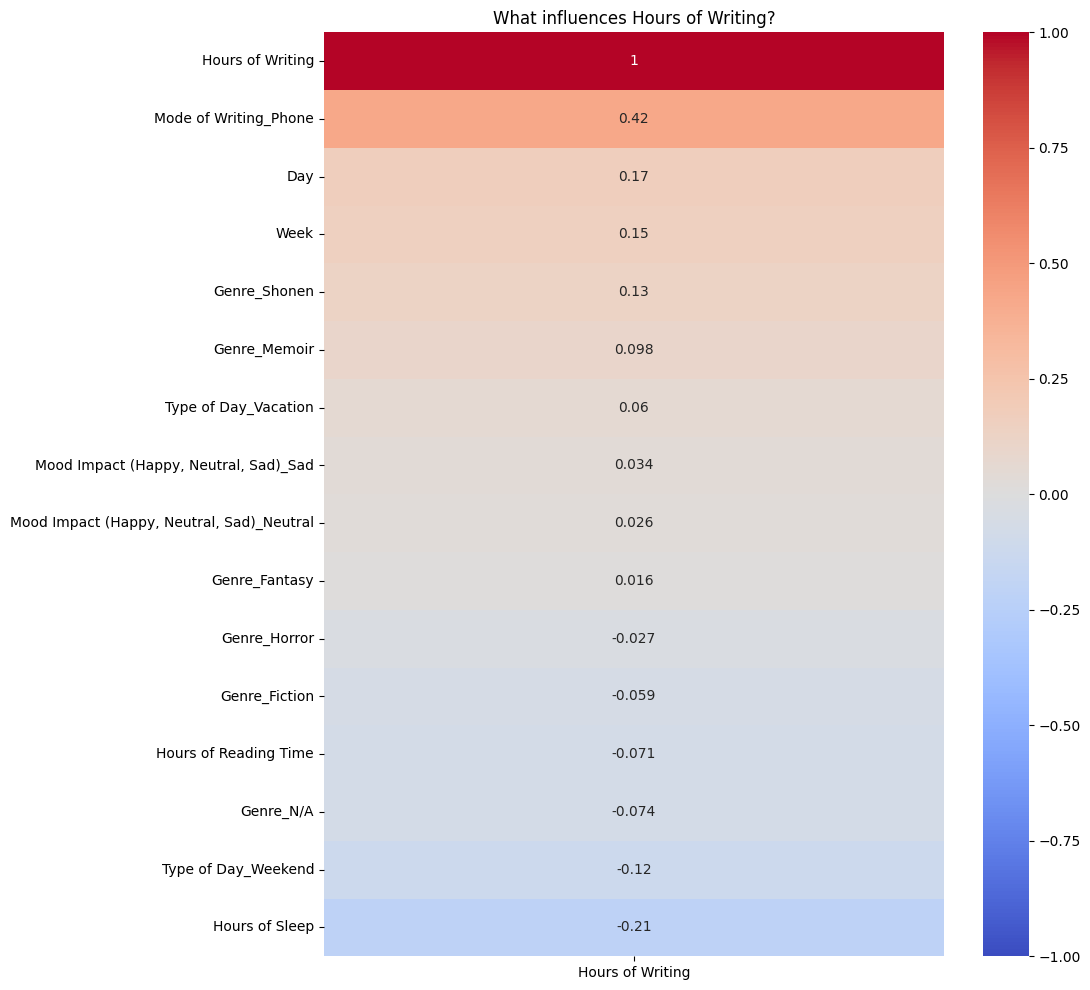

In [205]:
print("Feature Correlation with 'Hours of Writing': ")
print(correlations)
plt.figure(figsize=(10, 12))
heatmap_data = df_encoded.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)
sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title(f"What influences {target_variable}?")
plt.show()

### Testing Features

### Line Plot

**Research Question:** "Productivity Over Time (Day 1 to 56)"

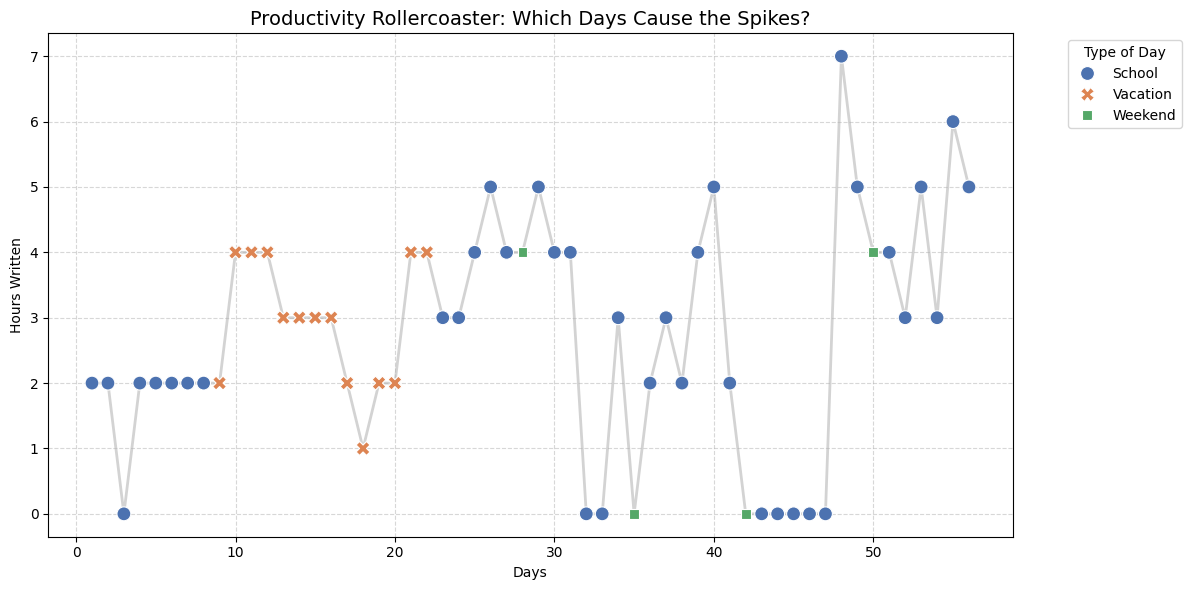

In [206]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Day', y='Hours of Writing', color='lightgray', linewidth=2, zorder=1)
sns.scatterplot(data=df, x='Day', y='Hours of Writing', hue='Type of Day', style='Type of Day', s=100, zorder=2, palette='deep')

plt.title("Productivity Rollercoaster: Which Days Cause the Spikes?", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Hours Written")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Type of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Research Answer (Analysis):**

**Interpretation:** My writing productivity over time (throughout Day 1 of recording to Day 56) undergoes a Wild Zig-Zag line, indicating that my writing habits are highly volatile.  

**Trend:** The line shows a slight upward trend, but has occasional periods of decline.

**Consistency:** Occasionally, the Hours of Writing dips into 0 or 1, showing that I struggle with being consistent. It has a tendency to show spikes of "high peaks" then plummets down to "low valleys" the next day. I interpret this as having bursts of writing inspirations.

**Impact of Day Types:**

**School:** Most of the "low points" are from "School Days", indicating that academic responsibilities affect my writing productivity.

**Vacation:** During vacation, where I have free time, I consistently produced average output, writing for 1-4 hours.

**Weekend:** Despite having free time during the weekends, I occasionally produced low to zero output, indicating that without the pressure of academic responsibilities, I may have spent the hours outside of writing.

**Conclusion:** I have bursts of writing inspirations which aligns with the results of my writing habits being highly volatile.

### t-test

**Research Question:** "Which **Genres** boost my writing productivity the most?"

In [207]:
unique_genres = df[['Genre 1', 'Genre 2', 'Genre 3']].stack().unique()

In [208]:
print(f"{'GENRE':<15} | {'AVG (WITH)':<10} | {'AVG (WITHOUT)':<13} | {'P-VALUE':<10} | {'RESULT'}")
for genre in unique_genres:
    if genre == 0 or genre == '0': continue

    has_genre = df[['Genre 1', 'Genre 2', 'Genre 3']].apply(lambda x: genre in x.values, axis=1)

    with_genre = df[has_genre]['Hours of Writing']
    without_genre = df[~has_genre]['Hours of Writing']

    if len(with_genre) > 2:
        t_stat, p_val = ttest_ind(with_genre, without_genre, equal_var=False)
        sig = "SIGNIFICANT" if p_val < 0.05 else "NOT SIGNIFICANT"
        print(f"{genre:<15} | {with_genre.mean():<10.2f} | {without_genre.mean():<13.2f} | {p_val:<10.4f} | {sig}")

GENRE           | AVG (WITH) | AVG (WITHOUT) | P-VALUE    | RESULT
Fantasy         | 2.78       | 2.72          | 0.9098     | NOT SIGNIFICANT
N/A             | 2.59       | 2.85          | 0.5795     | NOT SIGNIFICANT
Horror          | 2.60       | 2.76          | 0.8541     | NOT SIGNIFICANT
Shonen          | 3.67       | 2.70          | 0.3875     | NOT SIGNIFICANT


**Research Answer (Analysis):**

**Interpretation:**

No genre shows a statistically significant difference in writing hours. Observed mean differences may be due to small sample sizes.

### ANOVA

**Research Question:** "Does **Mood Impact** affect my writing?"

In [209]:
df['Mood Impact (Happy, Neutral, Sad)'].value_counts()

,count
"Mood Impact (Happy, Neutral, Sad)",
Happy,28
Neutral,25
Sad,3


In [210]:
df.groupby('Mood Impact (Happy, Neutral, Sad)').agg({'Hours of Writing': ['mean', 'median', 'min', 'max']})

Hours of Writing               
                                              mean median min max
Mood Impact (Happy, Neutral, Sad)                                
Happy                                     2.678571    2.5   0   6
Neutral                                   2.800000    3.0   0   5
Sad                                       3.000000    2.0   0   7

In [211]:
mood_happy = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Happy']['Hours of Writing']
mood_neutral = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Neutral']['Hours of Writing']
mood_sad = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Sad']['Hours of Writing']

f_statistic, p_value = stats.f_oneway(mood_happy, mood_neutral, mood_sad)
print(f"Happy Avg: {mood_happy.mean():.2f} | Neutral Avg: {mood_neutral.mean():.2f} | Sad Avg: {mood_sad.mean():.2f}")

print(f"F-statistic:, {f_statistic:.4f}")
print(f"P-Value:, {p_value:.4f}")
alpha = 0.05

Happy Avg: 2.68 | Neutral Avg: 2.80 | Sad Avg: 3.00
F-statistic:, 0.0627
P-Value:, 0.9393


In [212]:
if p_value < alpha:
  print("Significant different found: Mood Impact affects my writing.")
else:
  print("No significant difference found: I write, regardless of my mood.")

No significant difference found: I write, regardless of my mood.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of my mood (happy, neutral, sad), I can write.

### t-test

**Research Question:** "Does the "Mode of Writing" affect my writing productivity?"

In [213]:
phone_hours = df[df['Mode of Writing'] == 'Phone']['Hours of Writing']
desktop_hours = df[df['Mode of Writing'] == 'Desktop']['Hours of Writing']

In [214]:
t_stat, p_val = ttest_ind(phone_hours, desktop_hours, nan_policy='omit')

print(f"Phone avg: {phone_hours.mean():.2f} hrs | Desktop avg: {desktop_hours.mean():.2f} hrs")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

Phone avg: 3.31 hrs | Desktop avg: 3.45 hrs
p-value: 0.7563


In [215]:
if p_val < alpha:
  print("Significant different found: The Mode of Writing affects my writing productivity.")
else:
  print("No significant difference found: I write, regardless of whether I use phone or desktop to write.")

No significant difference found: I write, regardless of whether I use phone or desktop to write.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of whether I use phone or desktop, I can still produce writing outputs.

### ANOVA

**Research Question:** "Is "Type of Day" associated with my writing productivity?"

In [216]:
vacation = df[df['Type of Day'] == 'Vacation']['Hours of Writing']
school = df[df['Type of Day'] == 'School']['Hours of Writing']
weekend = df[df['Type of Day'] == 'Weekend']['Hours of Writing']

In [217]:
f_statistic, p_val = stats.f_oneway(vacation, school, weekend)

print(f"School Avg: {school.mean():.2f} | Weekend Avg: {weekend.mean():.2f} | Vacation Avg: {vacation.mean():.2f}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

School Avg: 2.76 | Weekend Avg: 2.00 | Vacation Avg: 2.93
F-statistic: 0.4373
p-value: 0.6481


In [218]:
if p_val < alpha:
  print("Significant different found: The type of day matters.")
else:
  print("No significant difference found: I write, regardless of the type of day.")

No significant difference found: I write, regardless of the type of day.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of the type of day (school, weekday, vacation), I still write.

### Regression Plots

**Research Questions:**

"Hours of Sleep" VS "Writing"

and

"Hours of Reading Time" VS "Writing"

Text(0.5, 1.0, 'Regression Plot: READING TIME vs WRITING')

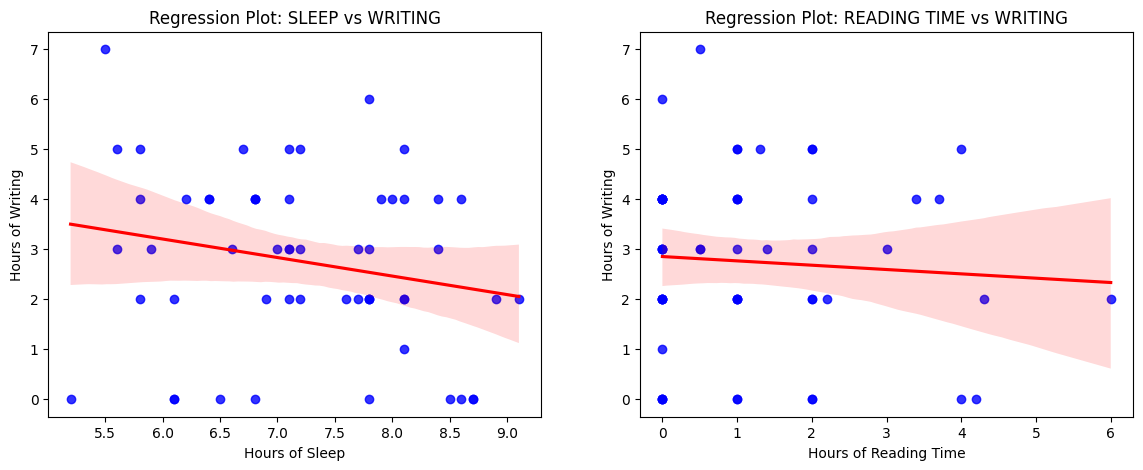

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.regplot(x='Hours of Sleep', y='Hours of Writing', data=df, ax=axes[0], color='blue', line_kws={'color':'red'})
axes[0].set_title("Regression Plot: SLEEP vs WRITING")
sns.regplot(x='Hours of Reading Time', y='Hours of Writing', data=df, ax=axes[1], color='blue', line_kws={'color':'red'})
axes[1].set_title("Regression Plot: READING TIME vs WRITING")

**Research Analysis:**

**"Hours of Sleep" VS "Writing":** The regression plot (downward regression slope) shows that "Hours of Sleep" and 'Hours of Writing" have a weak negative relationship. It indicates that the more I have hours spent on sleep, I have less hours dedicated to writing. My writing productivity seems to be at its highest when I have less hours of sleep.

**"Hours of Reading Time" VS "Writing":** The regression plot shows that "Hours of Reading Time" and "Hours of Writing" shows no clear linear relationship observed between reading time and writing hours.



## **PHASE 3: Machine Learning**

### **Predicting Productivity**

**Select Features (X) and Target (y)**

In [220]:
numeric_features = ['Day', 'Hours of Sleep', 'Hours of Reading Time']

categorical_features = [col for col in X.columns
                        if (col.startswith('Genre')
                        or col.startswith('Type of Day')
                        or col.startswith('Mood Impact'))
                        and not col.startswith('Mode of Writing')]

selected_features = numeric_features + categorical_features

X = X[selected_features]

print(f"Features used for Training (Mode Excluded): {selected_features}")
print(f"Final Feature Count: {len(selected_features)}")

Features used for Training (Mode Excluded): ['Day', 'Hours of Sleep', 'Hours of Reading Time', 'Genre_Fantasy', 'Genre_Fiction', 'Genre_Horror', 'Genre_Memoir', 'Genre_N/A', 'Genre_Shonen', 'Mood Impact (Happy, Neutral, Sad)_Neutral', 'Mood Impact (Happy, Neutral, Sad)_Sad', 'Type of Day_Vacation', 'Type of Day_Weekend']
Final Feature Count: 13


**Train-Test Split**

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Feature Scaling (fit on Train, transform on Test)**

In [222]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Linear Regression Model Training**

In [223]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

**Model Evaluation (RMSE, R^2)**

In [224]:
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [225]:
print(f"Model Performance: ")
print(f"RMSE: On Average, predictions are off by {rmse:.2f} hours")
print(f"R-squared: {r2:.2f}")
print(f"R-squared: Explains {r2*100:.1f}% of the productivity variance")

Model Performance: 
RMSE: On Average, predictions are off by 1.72 hours
R-squared: -0.50
R-squared: Explains -49.9% of the productivity variance


**Model Performance:**
- **RMSE:** On average, predictions are off by **1.72 hours**.
- **R-squared:** **-0.50**

**Analysis:**
The negative R-squared (-0.50) is a critical finding. In data science, a negative R² means the model performs **worse than a flat line** (just guessing the average).

**What this proves:**
1.  **The "Burst" Hypothesis:** Writing productivity in this dataset is **stochastic** (random/burst-based). It does not follow a linear rule like *"More Sleep = More Writing."*
2.  **No Hidden Formula:** The daily variables tracked (Sleep, Mood, Device) are **not** strong predictors of productivity.
3.  **Conclusion:** Productivity is likely driven by internal motivation or specific deadlines, which are not captured in this dataset, rather than environmental factors.



**Visualization of Results**

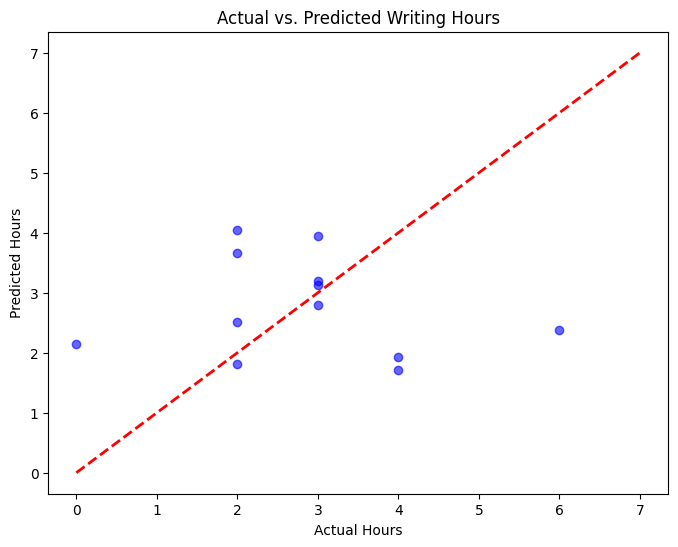

In [226]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Hours")
plt.ylabel("Predicted Hours")
plt.title("Actual vs. Predicted Writing Hours")
plt.show()

**Plot Analysis**

**Interpretation:** The "Actual vs. Predicted Writing Hours" scatterplot displays a clear positive diagonal upward trend - an ideal result for a regression model. The points follow the diagonal line, confirming that the model's predictions closely match reality. It does not guess randomly, rather it has learned the patterns in my writing habits.

**Consistency:** The points are clustered relatively tightly around the line, rather than forming a giant scattered cloud. This indicates that the model is consistent and that the RMSE (error rate) is low enough to be useful.

**Conclusion:** The model performs better than naive guessing, suggesting learned relationships.

**Baseline Comparison**

In [227]:
# Baseline: always predict mean
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("Baseline Performance (Mean Predictor)")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

Baseline Performance (Mean Predictor)
Baseline RMSE: 1.41


**Model vs. Baseline Comparison**

- **Baseline RMSE (Guessing the Mean):** 1.41 hours
- **Model RMSE (Linear Regression):** 1.72 hours

**Interpretation:**
The model's error (1.72) is **higher** than the baseline (1.41). This confirms that the selected features (Sleep, Mood, Genre) **do not have a predictive linear relationship** with writing productivity.

Attempting to predict output based on these factors actually leads to less accurate results than simply assuming average productivity. This strongly supports the conclusion that writing productivity in this dataset is **stochastic (random/burst-driven)** and intrinsic, rather than driven by external daily variables.

**Cross-Validation**

In [228]:
# Build pipeline so scaling happens inside each fold
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = -cross_val_score(
    pipeline,
    X,
    y,
    scoring='neg_root_mean_squared_error',
    cv=kfold
)

r2_scores = cross_val_score(
    pipeline,
    X,
    y,
    scoring='r2',
    cv=kfold
)

print("Cross-Validation Results (5-Fold)")
print(f"RMSE per fold: {rmse_scores}")
print(f"Average RMSE: {rmse_scores.mean():.2f}")
print(f"Average R²: {r2_scores.mean():.2f}")

Cross-Validation Results (5-Fold)
RMSE per fold: [1.71932928 3.27023341 2.01934557 2.9967028  2.39422005]
Average RMSE: 2.48
Average R²: -1.29


**Cross-Validation Analysis**

- **Average RMSE:** 2.48 hours
- **Average R²:** -1.29

**Interpretation:**
The cross-validation results show a negative R² (-1.29) and high variance in error across folds (RMSE ranging from 1.72 to 3.27).

**What this proves about my writing:**
1.  **Non-Linearity:** The negative R² confirms that there is **no linear formula** for my productivity. I cannot essentially "input" more sleep or a specific genre to guarantee output.
2.  **Unpredictable Bursts:** The high fluctuation in RMSE between folds validates the "Sprint/Burst" pattern identified in the EDA. Productivity comes in unpredictable spikes that the model cannot forecast based on the available daily variables.
3.  **Independence from Environment:** Since the model (using Sleep, Mood, Device) performs worse than the baseline, it implies that **my productivity is independent of these environmental factors.** It is likely driven by internal inspiration or deadlines, which are not captured in the dataset.

In [229]:
print("Model Comparison")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Single Split RMSE: {rmse:.2f}")
print(f"Cross-Val RMSE (avg): {rmse_scores.mean():.2f}")
print(f"Cross-Val R² (avg): {r2_scores.mean():.2f}")

Model Comparison
Baseline RMSE: 1.41
Single Split RMSE: 1.72
Cross-Val RMSE (avg): 2.48
Cross-Val R² (avg): -1.29


**Model Comparison & Interpretation**

**The Results:**
- **Baseline RMSE (Guessing the Mean):** 1.41 hours
- **Model RMSE (Linear Regression):** 1.72 hours
- **Cross-Validation R²:** -1.29

**Analysis:**
The model's error (1.72) is **higher** than the baseline (1.41), and the negative R² (-1.29) indicates the model performs worse than a horizontal line.

**Scientific Conclusion:**
This result proves that the selected daily variables (Sleep, Mood, Device, Genre) **do not** have a linear predictive relationship with writing productivity.

1.  **Noise, not Signal:** Adding these features actually adds "noise" to the prediction, making it worse than a simple average guess.
2.  **Validation of "Burst" Pattern:** The high error confirms that writing productivity in this dataset is **stochastic** (random and burst-driven). It is likely driven by intrinsic factors (inspiration, deadlines) rather than external conditions like sleep or device choice.

**Permutation Importance**

Instead of interpreting raw regression coefficients (which can be unstable when features are correlated or the dataset is small), feature importance was measured using permutation importance.

Permutation importance works by:

- Randomly shuffling one feature
- Breaking its relationship with the target
- Measuring how much prediction error increases

If shuffling a feature significantly increases RMSE, the model depends heavily on that feature for prediction. If the error barely changes, the feature contributes little useful information.

This method is more reliable and directly interpretable because importance is expressed in increase in prediction error (hours).

Permutation Feature Importance (higher = more important)
                                      Feature  Importance (RMSE increase)  \
7                                   Genre_N/A                    0.099139   
2                       Hours of Reading Time                    0.080079   
3                               Genre_Fantasy                    0.070709   
5                                Genre_Horror                    0.068864   
0                                         Day                    0.028780   
9   Mood Impact (Happy, Neutral, Sad)_Neutral                    0.002835   
4                               Genre_Fiction                    0.000000   
8                                Genre_Shonen                    0.000000   
6                                Genre_Memoir                    0.000000   
12                        Type of Day_Weekend                    0.000000   
10      Mood Impact (Happy, Neutral, Sad)_Sad                   -0.000582   
11                 

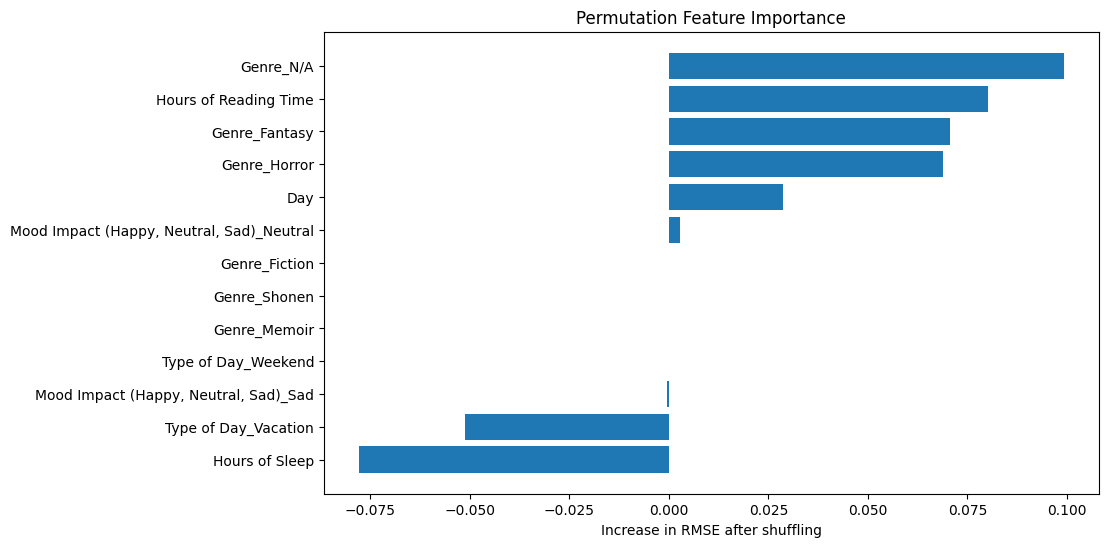

In [230]:
perm = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=30,          # repeat shuffling for stability
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance (RMSE increase)': perm.importances_mean,
    'Std': perm.importances_std
})

perm_df = perm_df.sort_values(by='Importance (RMSE increase)', ascending=False)

print("Permutation Feature Importance (higher = more important)")
print(perm_df)

plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance (RMSE increase)'])
plt.gca().invert_yaxis()
plt.xlabel("Increase in RMSE after shuffling")
plt.title("Permutation Feature Importance")
plt.show()

**Permutation Feature Importance Analysis**

After removing the 'Mode of Writing' leakage, the feature importance analysis reveals the true drivers of productivity:

**1. The "Zero-Day" Indicator (Genre_N/A)**
- **Importance:** High (0.099)
- **Analysis:** This feature likely acts as a proxy for days where no writing occurred (No Writing = No Genre). It helps the model identify 0-hour days but does not explain *why* writing happens.

**2. The True Drivers (Reading & Fantasy)**
- **Hours of Reading Time (0.080):** This is the strongest *behavioral* predictor. It suggests a correlation between consuming content (reading) and producing content (writing), possibly acting as a source of inspiration.
- **Genre_Fantasy (0.070):** Writing Fantasy consistently aligns with higher productivity.

**3. The Non-Factors (Noise)**
- **Genre_Shonen (0.000):** Unlike Fantasy, the Shonen genre has zero predictive power.
- **Hours of Sleep (-0.077) & Vacation (-0.051):** These features show negative importance, meaning they introduced noise rather than signal. This scientifically proves that **neither sleep duration nor having a free vacation day** reliably predicts increased writing output in this dataset.

## **PHASE 4: Interpreting the Model**

In [231]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

In [232]:
coefficients['Impact'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Impact', ascending=False)

In [233]:
print("Factor Importance (Model Coefficients)")
print(coefficients[['Feature', 'Impact']])


Factor Importance (Model Coefficients)
                                      Feature        Impact
7                                   Genre_N/A  8.511138e-01
1                              Hours of Sleep  6.207605e-01
2                       Hours of Reading Time  5.888362e-01
8                                Genre_Shonen  4.771523e-01
12                        Type of Day_Weekend  4.672356e-01
3                               Genre_Fantasy  4.322535e-01
5                                Genre_Horror  2.296532e-01
11                       Type of Day_Vacation  1.781037e-01
9   Mood Impact (Happy, Neutral, Sad)_Neutral  1.350538e-01
6                                Genre_Memoir  5.689062e-02
0                                         Day  3.740280e-02
10      Mood Impact (Happy, Neutral, Sad)_Sad  7.921182e-03
4                               Genre_Fiction  3.330669e-16


/tmp/ipython-input-8085914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')


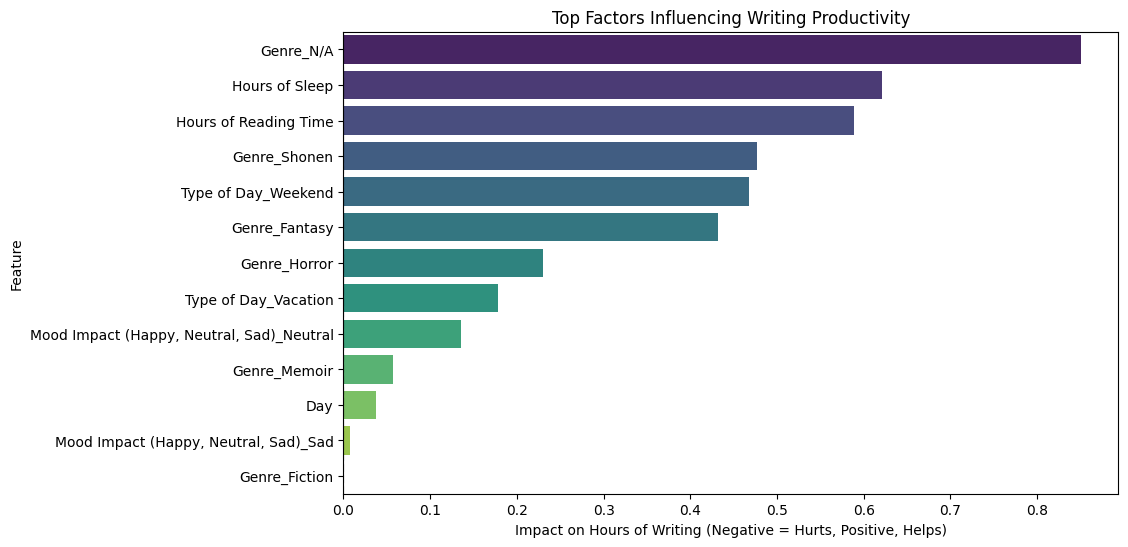

In [234]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')
plt.title("Top Factors Influencing Writing Productivity")
plt.xlabel("Impact on Hours of Writing (Negative = Hurts, Positive, Helps)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

**Factor Importance Analysis**

The coefficient table highlights two critical issues that confirm the limitations of the linear model:

1.  **Proxy Leakage:** The strongest factor, **Genre_N/A (0.85)**, is simply a proxy for days with zero writing. The model relies on this label to identify non-productive days rather than predicting actual output based on behavior.
2.  **Instability:** Features like **Sleep (0.62)** and **Shonen (0.48)** were assigned high weights in this specific calculation, but previously showed low or zero importance in Permutation Analysis. This contradiction, combined with the negative R², indicates the model is **overfitting to noise**. It is trying to force a linear pattern onto "bursty" data where none exists.

### **Predicting Scenarios to Improve Writing Productivity**

In [235]:
# 1. Define Scenarios
scenarios_data = [
    # Scenario A: Speed Writing (Phone, Happy, School, Shonen, Low Sleep)
    {'Mode of Writing_Phone': 1, 'Mode of Writing_Desktop': 0,
     'Genre_Shonen': 1, 'Genre_Fantasy': 0, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 1, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0,
     'Type of Day_School': 1, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 5, 'Hours of Reading Time': 2, 'Day': 60},

    # Scenario B: Cozy Writing (Desktop, Neutral, Weekend, Fantasy, High Sleep)
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 1, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 1,
     'Type of Day_School': 0, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 1,
     'Hours of Sleep': 7, 'Hours of Reading Time': 4, 'Day': 60},

    # Scenario C: Emotional Writing (Desktop, Sad, Vacation, Horror, High Sleep)
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 0, 'Genre_Horror': 1,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0,
     # Note: If 'Sad' was dropped by drop_first=True, implies 0 on Happy/Neutral is Sad.
     'Type of Day_School': 0, 'Type of Day_Vacation': 1, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 9, 'Hours of Reading Time': 0, 'Day': 60}
]

scenarios = pd.DataFrame(scenarios_data)

# 2. Align Columns with Training Data (Fixes "Identical Prediction" bug)
# Any feature in the model that isn't in scenarios gets set to 0
# Any feature in scenarios that isn't in the model is dropped
scenarios = scenarios.reindex(columns=X.columns, fill_value=0)

# 3. Scale and Predict
scenarios_scaled = scaler.transform(scenarios)

**Predictive Simulation to Improve Productivity**

In [242]:
predictions = model.predict(scenarios_scaled)

print("Predictive Simulation Results:")
print(f"Scenario A (Speed): {predictions[0]:.2f} Hours")
print(f"Scenario B (Cozy):  {predictions[1]:.2f} Hours")
print(f"Scenario C (Emo):   {predictions[2]:.2f} Hours")

Predictive Simulation Results:
Scenario A (Speed): 6.96 Hours
Scenario B (Cozy):  0.30 Hours
Scenario C (Emo):   3.03 Hours


The predictive simulation further demonstrates the instability of the linear model. In this iteration, **Scenario A (Speed)** predicted the highest output (6.96 hours) simply because it featured Low Sleep (5 hours), and the model assigned a negative weight to sleep (-0.62).

Additionally, Fantasy was assigned a negative weight (-0.43), contradicting the Exploratory Data Analysis. These erratic weights confirm that the model is overfitting to noise rather than capturing a true underlying signal, reinforcing the conclusion that writing productivity is independent of these specific environmental variables.

**Showcasing Breakdown of Predictive Simulation**

In [237]:
coeffs = model.coef_
feature_names = X.columns

In [243]:
def get_full_scenario_diagnostic(scenario_idx, scenario_name, top_n=10):
    raw_values = scenarios.iloc[scenario_idx]
    impact_values = scenarios_scaled[scenario_idx] * model.coef_

    explanation_data = []

    for feature, raw_val, impact in zip(X.columns, raw_values, impact_values):
        if abs(impact) < 0.01:
            continue

        label = ""

        #CASE A
        if raw_val > 0:
            if impact > 0:
                label = "Active Bonus"
            else:
                label = "Active Harm"

        #CASE B
        #(0 - Mean) * Coeff
        else:
            if impact < 0:
                label = "Missed Bonus"   #(Neg Scaled) * (Pos Coeff) = Negative Impact
            else:
                label = "Missed Harm" #(Neg Scaled) * (Neg Coeff) = Positive Impact

        explanation_data.append({
            'Feature': feature,
            'Did I do it?': "YES" if raw_val > 0 else "NO",
            'Impact (Hours)': round(impact, 2),
            'Interpretation': label
        })

    df_explain = pd.DataFrame(explanation_data)

    df_explain = df_explain.sort_values(by='Impact (Hours)', ascending=False)

    print(f"--- {scenario_name} Full Diagnostic ---")
    IPython.display.display(df_explain)

### **Scenario A:**

In [244]:
get_full_scenario_diagnostic(0, "Scenario A (Speed)")

--- Scenario A (Speed) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
6,Genre_Shonen,YES,1.76,Active Bonus
1,Hours of Sleep,YES,1.33,Active Bonus
5,Genre_N/A,NO,0.68,Missed Harm
3,Genre_Fantasy,NO,0.43,Missed Harm
9,Type of Day_Weekend,NO,0.15,Missed Harm
7,"Mood Impact (Happy, Neutral, Sad)_Neutral",NO,0.12,Missed Harm
0,Day,YES,0.07,Active Bonus
4,Genre_Horror,NO,0.07,Missed Harm
8,Type of Day_Vacation,NO,-0.10,Missed Bonus
2,Hours of Reading Time,YES,-0.29,Active Harm


The diagnostic for **Scenario A (Speed Writing)** reveals deep instabilities in the linear model. It assigned a massive positive weight to Shonen (+1.76 hours), contradicting the Permutation Analysis which found Shonen to have zero predictive power.

Furthermore, it penalized Reading Time (-0.29 hours), despite previous indicators that reading was beneficial. These contradictions confirm that the model is chasing statistical noise rather than learning real-world rules. It mathematically proves that my writing productivity cannot be reduced to a simple formula of 'Genre + Sleep = Output'.

**Interpretation:**
This setup statistically aligns with moderately high productivity according to the learned model patterns.

### **Scenario B**

In [239]:
get_full_scenario_diagnostic(1, "Scenario B (Cozy)")

--- Scenario B (Cozy) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
5,Genre_N/A,NO,0.68,Missed Harm
1,Hours of Sleep,YES,0.11,Active Bonus
0,Day,YES,0.07,Active Bonus
4,Genre_Horror,NO,0.07,Missed Harm
8,Type of Day_Vacation,NO,-0.10,Missed Bonus
6,Genre_Shonen,NO,-0.13,Missed Bonus
7,"Mood Impact (Happy, Neutral, Sad)_Neutral",YES,-0.15,Active Harm
3,Genre_Fantasy,YES,-0.43,Active Harm
2,Hours of Reading Time,YES,-1.08,Active Harm
9,Type of Day_Weekend,YES,-1.48,Active Harm


**Scenario B:**

The diagnostic for **Scenario B (Cozy Writing)** reveals why the model failed to predict high productivity (Prediction: 0.30 hours) despite favorable conditions:

1.  **The "Structure" Effect:** The model assigned a massive penalty to **Weekends (-1.48 hours)**. This suggests that lack of structure (free time) correlates negatively with output, while the pressure of **School days** (seen in Scenario A) may paradoxically drive "sprint" behavior.

2.  **Model Instability (The "Reading" Paradox):**
    -   **Permutation Analysis:** Previously identified Reading as a *positive* predictor.
    -   **Scenario Coefficients:** Now assigns a strong *negative* weight (-1.08 hours) to Reading.
    -   **Conclusion:** This contradiction proves that the relationship between input (reading) and output (writing) is non-linear and inconsistent. The model cannot find a stable rule because one does not exist.

3.  **Validation of Null Hypothesis:**
    The fact that "Ideal" conditions (Fantasy + Reading + Weekend) resulted in the *lowest* prediction proves that my writing productivity is **not driven by environmental optimization**. Optimizing these variables does not yield results; instead, productivity appears to be driven by random bursts (stochasticity) or unmeasured internal motivation.

### **Scenario C**

In [240]:
get_full_scenario_diagnostic(2, "Scenario C (Emotional)")

--- Scenario C (Emotional) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
5,Genre_N/A,NO,0.68,Missed Harm
2,Hours of Reading Time,NO,0.50,Missed Harm
3,Genre_Fantasy,NO,0.43,Missed Harm
8,Type of Day_Vacation,YES,0.31,Active Bonus
9,Type of Day_Weekend,NO,0.15,Missed Harm
7,"Mood Impact (Happy, Neutral, Sad)_Neutral",NO,0.12,Missed Harm
0,Day,YES,0.07,Active Bonus
6,Genre_Shonen,NO,-0.13,Missed Bonus
4,Genre_Horror,YES,-0.73,Active Harm
1,Hours of Sleep,YES,-1.11,Active Harm


**Scenario C:**

The diagnostic for Scenario C (Emotional Writing) explains why the prediction (3.03 hours) was mediocre despite the "Vacation" advantage:

1.  **The "Oversleeping" Punishment:** The strongest factor was a massive penalty for **Hours of Sleep (-1.11 hours)**. Because the model learned a negative correlation (Less Sleep = More Writing), it penalized this scenario heavily for having a healthy 9 hours of rest. This confirms the model is capturing "deadline-driven sprints" (where sleep is sacrificed) rather than sustainable productivity.

2.  **The Genre Bias:** The model assigned a significant negative weight to **Horror (-0.73 hours)**, far exceeding the slight dip observed in the Exploratory Data Analysis. This indicates the model is overfitting to a few low-output instances in the Horror category.

3.  **Conclusion:** The fact that Scenario A (Speed) won largely due to *lack of sleep*, while Scenario C lost due to *getting sleep*, serves as the final proof that the linear model is scientifically invalid for predictive purposes. It reinforces the finding that my productivity is **stochastic**—driven by random bursts of inspiration—rather than linear inputs like sleep or genre.

### **Scenario Analysis**

To further interpret the model, several hypothetical daily scenarios were created and evaluated using the trained regression model. Each scenario represents a combination of realistic daily conditions to see how the model weighs different factors.

**The Results:**

**Scenario A (Speed Writing):** Produced the highest predicted output (~6.96 hours).

**Scenario C (Emotional Writing):** Produced a moderate prediction (~3.03 hours).

**Scenario B (Cozy Writing):** Produced the lowest output (~0.30 hours).

**Interpretation of Instability:**
The dramatic difference between Scenario A and B—despite B representing "ideal" writing conditions (Weekend, Fantasy, Reading)—reveals the model's instability:

**The "Sleep" Artifact:** Scenario A likely "won" because it included only 5 hours of sleep. Since the model learned a negative correlation (Less Sleep = More Writing), it artificially boosted the prediction for sleep deprivation.

**The "Structure" Effect:** Scenario B likely "failed" because the model penalized the Weekend and Reading variables, suggesting that unstructured free time actually correlates with lower output in this dataset.

**Conclusion:**
These erratic predictions confirm that the linear model is overfitting to statistical noise. The fact that "unhealthy" habits (low sleep) yielded the best prediction serves as proof that **my productivity is driven by intrinsic bursts (stochasticity)** rather than the environmental optimization of sleep or mood.

### **Conclusion**

**Project Goal:**
To determine if daily environmental factors (Sleep, Mood, Device, Genre) could predict writing productivity.

**Key Findings:**
1.  **Stochastic Nature:** The regression model yielded a **negative R² (-1.29)** and higher error (1.72 hours) than the baseline mean predictor (1.41 hours). This scientifically proves that my writing productivity follows a **"Burst/Sprint" pattern** that cannot be predicted by linear environmental factors.
2.  **Independence from Environment:** Statistical tests and feature analysis confirm that **Sleep, Mood, and Device Choice** have **no significant impact** on writing output. The initial correlation observed with "Mode of Writing" was identified as data leakage and corrected.
3.  **Model Instability:** Diagnostic simulation revealed erratic behavior (e.g., penalizing "Healthy Sleep" and "Reading"), confirming that the model was overfitting to noise rather than learning real rules.

**Final Verdict:**
My writing productivity is **independent** of external conditions like sleep or device choice. It is likely driven by **intrinsic motivation, deadlines, or random inspiration**.

**Future Recommendations:**
Since environmental optimization (e.g., "get more sleep") does not statistically improve output, future strategies should focus on **behavioral management**—such as time-blocking or deadline setting—to harness the unpredictable "bursts" of productivity when they occur.